In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.metrics import classification_report

df_train = pd.read_csv('./../data/processed/train_woe_features.csv')
df_valid = pd.read_csv('./../data/processed/valid_woe_features.csv')

print(f"Training: {len(df_train)} loans")
print(f"Validation: {len(df_valid)} loans")

feature_cols = ['int_rate_woe', 'fico_range_low_woe', 'dti_woe', 'annual_inc_woe',
                'loan_amnt_woe', 'inq_last_6mths_woe', 'revol_util_woe',
                'term_woe', 'grade_woe', 'home_woe']

X_train = df_train[feature_cols].values
y_train = df_train['default'].values

X_valid = df_valid[feature_cols].values
y_valid = df_valid['default'].values

print(f"\nFeatures: {len(feature_cols)}")
print(f"Training default rate: {y_train.mean():.2%}")
print(f"Validation default rate: {y_valid.mean():.2%}")

Training: 668181 loans
Validation: 168699 loans

Features: 10
Training default rate: 21.54%
Validation default rate: 23.12%


In [2]:
model = LogisticRegression(max_iter=1000, random_state=42)

model.fit(X_train, y_train)

print("Model trained")
print("\nFeature coefficients:")
for i in range(len(feature_cols)):
    coef = model.coef_[0][i]
    print(f"{feature_cols[i]:25s}: {coef:8.4f}")

print(f"\nIntercept: {model.intercept_[0]:.4f}")

Model trained

Feature coefficients:
int_rate_woe             :  -0.6610
fico_range_low_woe       :  -0.5008
dti_woe                  :  -0.5135
annual_inc_woe           :  -0.5407
loan_amnt_woe            :  -0.5197
inq_last_6mths_woe       :  -0.4195
revol_util_woe           :   0.2334
term_woe                 :   0.5540
grade_woe                :   0.0294
home_woe                 :   1.1811

Intercept: -1.4997


In [3]:
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]

auc_train = roc_auc_score(y_train, y_train_pred_proba)
auc_valid = roc_auc_score(y_valid, y_valid_pred_proba)

gini_train = 2 * auc_train - 1
gini_valid = 2 * auc_valid - 1

print("Model Performance:")
print(f"\nTraining Set:")
print(f"  AUC: {auc_train:.4f}")
print(f"  Gini: {gini_train:.4f}")

print(f"\nValidation Set:")
print(f"  AUC: {auc_valid:.4f}")
print(f"  Gini: {gini_valid:.4f}")

print(f"\nPredicted default rate:")
print(f"  Training: {y_train_pred_proba.mean():.2%}")
print(f"  Validation: {y_valid_pred_proba.mean():.2%}")

Model Performance:

Training Set:
  AUC: 0.7188
  Gini: 0.4376

Validation Set:
  AUC: 0.6968
  Gini: 0.3935

Predicted default rate:
  Training: 21.55%
  Validation: 22.67%


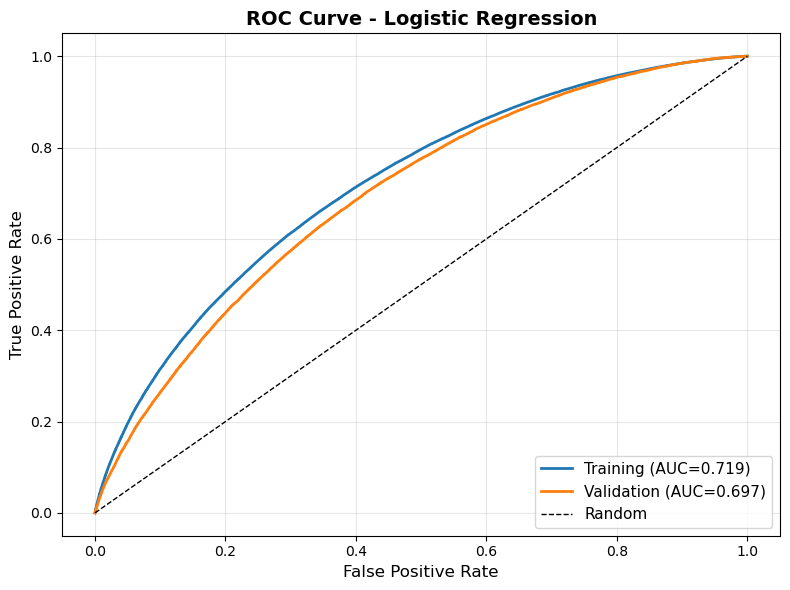

ROC curve saved


In [4]:
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
fpr_valid, tpr_valid, _ = roc_curve(y_valid, y_valid_pred_proba)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(fpr_train, tpr_train, label=f'Training (AUC={auc_train:.3f})', linewidth=2)
ax.plot(fpr_valid, tpr_valid, label=f'Validation (AUC={auc_valid:.3f})', linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', label='Random', linewidth=1)

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve - Logistic Regression', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./../figures/roc_curve.png', dpi=300, bbox_inches='tight')
plt.show()

print("ROC curve saved")

KS Statistic:
  Training: 0.3158
  Validation: 0.2862


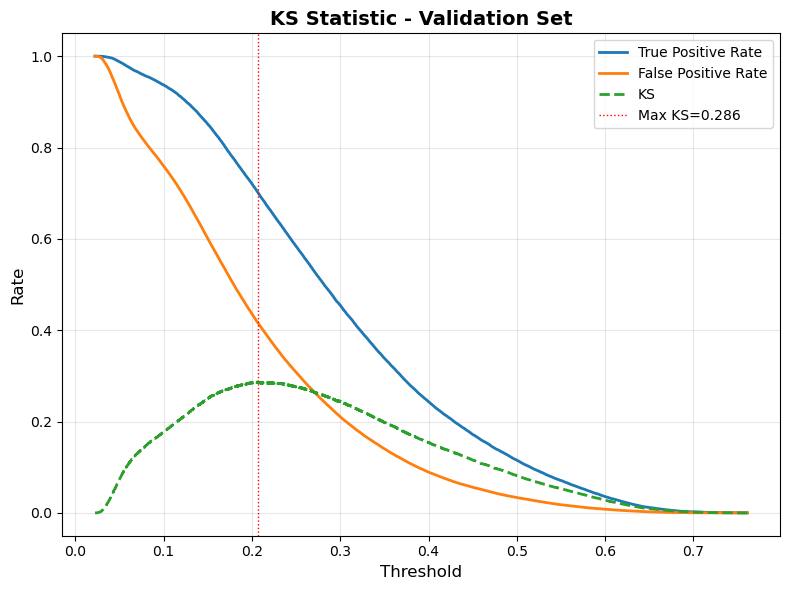

KS plot saved


In [5]:
def calculate_ks(y_true, y_pred_proba):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    ks = np.max(tpr - fpr)
    ks_threshold = thresholds[np.argmax(tpr - fpr)]
    return ks, ks_threshold

ks_train, ks_thresh_train = calculate_ks(y_train, y_train_pred_proba)
ks_valid, ks_thresh_valid = calculate_ks(y_valid, y_valid_pred_proba)

print(f"KS Statistic:")
print(f"  Training: {ks_train:.4f}")
print(f"  Validation: {ks_valid:.4f}")

fpr, tpr, thresholds = roc_curve(y_valid, y_valid_pred_proba)

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(thresholds, tpr, label='True Positive Rate', linewidth=2)
ax.plot(thresholds, fpr, label='False Positive Rate', linewidth=2)
ax.plot(thresholds, tpr - fpr, label='KS', linewidth=2, linestyle='--')

ax.axvline(ks_thresh_valid, color='red', linestyle=':', linewidth=1, 
           label=f'Max KS={ks_valid:.3f}')

ax.set_xlabel('Threshold', fontsize=12)
ax.set_ylabel('Rate', fontsize=12)
ax.set_title('KS Statistic - Validation Set', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./../figures/ks_statistic.png', dpi=300, bbox_inches='tight')
plt.show()

print("KS plot saved")

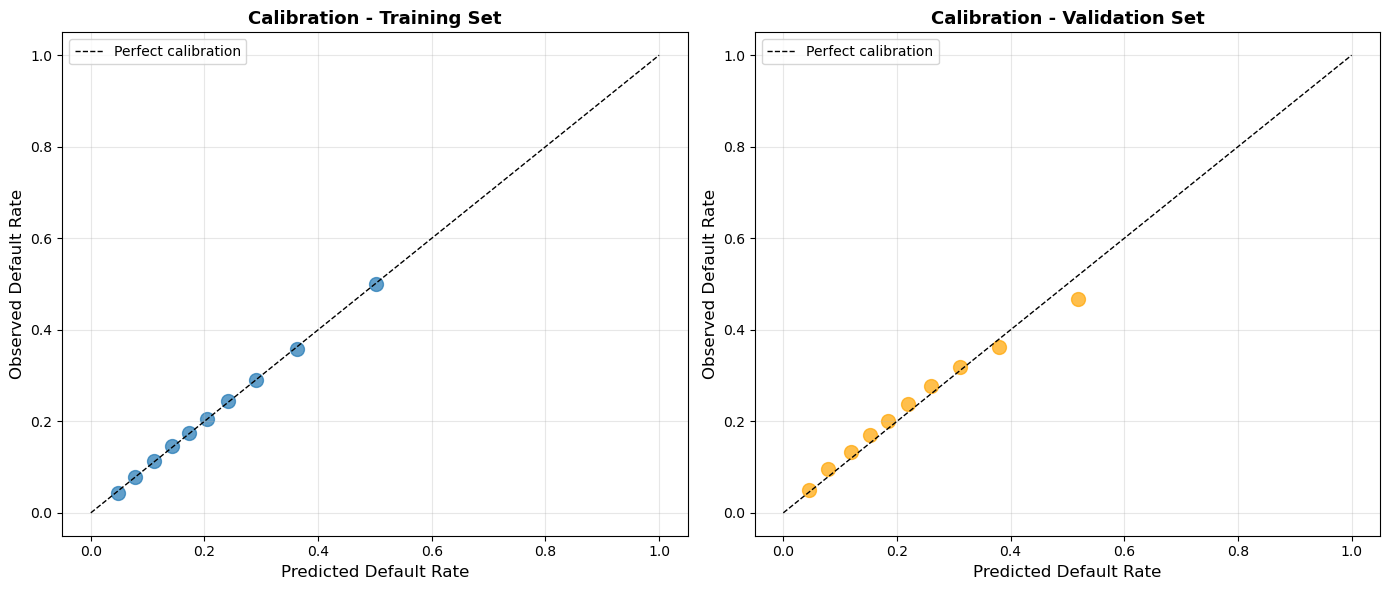

Calibration plot saved


In [6]:
def create_calibration_data(y_true, y_pred_proba, n_bins=10):
    df_cal = pd.DataFrame()
    df_cal['y_true'] = y_true
    df_cal['y_pred'] = y_pred_proba
    
    df_cal['decile'] = pd.qcut(df_cal['y_pred'], q=n_bins, labels=False, duplicates='drop')
    
    cal_stats = df_cal.groupby('decile').agg(
        count=('y_true', 'count'),
        observed=('y_true', 'mean'),
        predicted=('y_pred', 'mean')
    )
    
    return cal_stats

cal_train = create_calibration_data(y_train, y_train_pred_proba)
cal_valid = create_calibration_data(y_valid, y_valid_pred_proba)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

axes[0].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Perfect calibration')
axes[0].scatter(cal_train['predicted'], cal_train['observed'], s=100, alpha=0.7)
axes[0].set_xlabel('Predicted Default Rate', fontsize=12)
axes[0].set_ylabel('Observed Default Rate', fontsize=12)
axes[0].set_title('Calibration - Training Set', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot([0, 1], [0, 1], 'k--', linewidth=1, label='Perfect calibration')
axes[1].scatter(cal_valid['predicted'], cal_valid['observed'], s=100, alpha=0.7, color='orange')
axes[1].set_xlabel('Predicted Default Rate', fontsize=12)
axes[1].set_ylabel('Observed Default Rate', fontsize=12)
axes[1].set_title('Calibration - Validation Set', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('./../figures/calibration_plot.png', dpi=300, bbox_inches='tight')
plt.show()

print("Calibration plot saved")

In [8]:
import pickle
import os

os.makedirs('./../models', exist_ok=True)
os.makedirs('./../reports', exist_ok=True)

with open('./../models/logistic_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model saved")

performance_summary = f"""
LOGISTIC REGRESSION MODEL - PERFORMANCE SUMMARY
================================================

Training Set (2015-2016):
  Samples: {len(y_train):,}
  Default rate: {y_train.mean():.2%}
  AUC: {auc_train:.4f}
  Gini: {gini_train:.4f}
  KS: {ks_train:.4f}

Validation Set (2017):
  Samples: {len(y_valid):,}
  Default rate: {y_valid.mean():.2%}
  AUC: {auc_valid:.4f}
  Gini: {gini_valid:.4f}
  KS: {ks_valid:.4f}

Features Used: {len(feature_cols)}
{chr(10).join([f'  - {f}' for f in feature_cols])}

Calibration: Excellent (points closely follow diagonal)
Overfitting: Minimal (Gini difference = {gini_train - gini_valid:.4f})

Status: Model ready for deployment
"""

print(performance_summary)

with open('./../reports/model_performance_summary.txt', 'w') as f:
    f.write(performance_summary)

print("\nPerformance summary saved")

Model saved

LOGISTIC REGRESSION MODEL - PERFORMANCE SUMMARY

Training Set (2015-2016):
  Samples: 668,181
  Default rate: 21.54%
  AUC: 0.7188
  Gini: 0.4376
  KS: 0.3158

Validation Set (2017):
  Samples: 168,699
  Default rate: 23.12%
  AUC: 0.6968
  Gini: 0.3935
  KS: 0.2862

Features Used: 10
  - int_rate_woe
  - fico_range_low_woe
  - dti_woe
  - annual_inc_woe
  - loan_amnt_woe
  - inq_last_6mths_woe
  - revol_util_woe
  - term_woe
  - grade_woe
  - home_woe

Calibration: Excellent (points closely follow diagonal)
Overfitting: Minimal (Gini difference = 0.0440)

Status: Model ready for deployment


Performance summary saved
